In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import mode, skew, kurtosis
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adamax
from sklearn import preprocessing
from keras.optimizers import SGD
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

### Main data

In [11]:
data = pd.read_csv('https://raw.githubusercontent.com/Fairtexas5/Rainfall/main/Whole_data/old_dataset.csv')
data2 = pd.read_csv('https://raw.githubusercontent.com/Fairtexas5/Rainfall/main/Whole_data/New_data_2010.csv')
#data3 = pd.read_csv('https://raw.githubusercontent.com/Fairtexas5/Rainfall/main/Whole_data/New_data_2016.csv')

### BP1 Monthly data

### Creating Datasets Using Function


In [15]:
BP_data = [5, 6, 7, 8, 9] 
def Maker_dataset(dataset, name):
    for i, BP in enumerate(name): 
        num_cols = BP_data[i]
        for j in range(num_cols+1):
            BP[f't-{num_cols - j}'] = (dataset[j:90 - num_cols + j] * 10).reset_index(drop=True)
        
        BP.reset_index(drop=True, inplace=True)

In [19]:
dataset = data2

jun_column = dataset['JUN']
jul_column = dataset['JUL']
aug_column = dataset['AUG']
sep_column = dataset['SEP']
seasonal_column = dataset['JJAS']


JUN_BP1 = pd.DataFrame()
JUN_BP2 = pd.DataFrame()
JUN_BP3 = pd.DataFrame()
JUN_BP4 = pd.DataFrame()
JUN_BP5 = pd.DataFrame()

JUL_BP1 = pd.DataFrame()
JUL_BP2 = pd.DataFrame()
JUL_BP3 = pd.DataFrame()
JUL_BP4 = pd.DataFrame()
JUL_BP5 = pd.DataFrame()

AUG_BP1 = pd.DataFrame()
AUG_BP2 = pd.DataFrame()
AUG_BP3 = pd.DataFrame()
AUG_BP4 = pd.DataFrame()
AUG_BP5 = pd.DataFrame()

SEP_BP1 = pd.DataFrame()
SEP_BP2 = pd.DataFrame()
SEP_BP3 = pd.DataFrame()
SEP_BP4 = pd.DataFrame()
SEP_BP5 = pd.DataFrame()

SEAS_BP1 = pd.DataFrame()
SEAS_BP2 = pd.DataFrame()
SEAS_BP3 = pd.DataFrame()
SEAS_BP4 = pd.DataFrame()
SEAS_BP5 = pd.DataFrame()

June_Data_all = [JUN_BP1, JUN_BP2, JUN_BP3, JUN_BP4, JUN_BP5]
July_Data_all = [JUL_BP1, JUL_BP2, JUL_BP3, JUL_BP4, JUL_BP5]
Aug_Data_all = [AUG_BP1, AUG_BP2, AUG_BP3, AUG_BP4, AUG_BP5]
Sept_Data_all = [SEP_BP1, SEP_BP2, SEP_BP3, SEP_BP4, SEP_BP5]
Seasonal_Data_all = [SEAS_BP1, SEAS_BP2, SEAS_BP3, SEAS_BP4, SEAS_BP5]

# Generate data for each month
Maker_dataset(jun_column, June_Data_all)
Maker_dataset(jul_column, July_Data_all)
Maker_dataset(aug_column, Aug_Data_all)
Maker_dataset(sep_column, Sept_Data_all)
Maker_dataset(seasonal_column, Seasonal_Data_all)

for i in range(1):
    print(f"BP{i+1}:\n", June_Data_all[i])

BP1:
        t-5     t-4     t-3     t-2     t-1     t-0
0   2080.0  1892.0  1130.0  2279.0  1926.0  1233.0
1   1892.0  1130.0  2279.0  1926.0  1233.0  1424.0
2   1130.0  2279.0  1926.0  1233.0  1424.0  1304.0
3   2279.0  1926.0  1233.0  1424.0  1304.0  1900.0
4   1926.0  1233.0  1424.0  1304.0  1900.0  1876.0
..     ...     ...     ...     ...     ...     ...
80  1551.0  1617.0  1563.0  1382.0  1797.0  2079.0
81  1617.0  1563.0  1382.0  1797.0  2079.0  1453.0
82  1563.0  1382.0  1797.0  2079.0  1453.0  1151.0
83  1382.0  1797.0  2079.0  1453.0  1151.0  1573.0
84  1797.0  2079.0  1453.0  1151.0  1573.0  1461.0

[85 rows x 6 columns]


## -------------------------------------------------------------------------------------------------

# Modelling

## Ensembling


### Customised Initializer
Customised Initializer is discussed in the paper:

<p><i>Initial weights</i>: At the beginning, neural network is assigned with small random values, because choosing initial weights too large will make the neural network untrained. In this study, we have chosen the weight (<i>w<sub>mn</sub></i>) by using the following range expression (Sivanandam and Deepa 2007):</p>

<p>&#091; <sup>-3</sup>&frasl;<sub>&radic;<span>p<sub>m</sub></sub> , <sup>3</sup>&frasl;<sub>&radic;<span >p<sub>m</sub></sub> &#093;</p>

<p>where <i>p<sub>m</sub></i> is the number of elements in <i>n</i> time series data sets that neural network to processing element <i>m</i>.</p>


In [17]:
class Sivanandam(Initializer):
    def __init__(self, pm):
        self.pm = pm

    def __call__(self, shape, dtype=None):
        limit = 3 / np.sqrt(self.pm)
        return np.random.uniform(-limit, limit, size=shape)

In [19]:
def mapping_graph(y, y_pred, year_start):
    years = np.arange(year_start, year_start + len(y_pred_denorm))
    
    trace_pred = go.Scatter(x=years, y=y_pred, mode='lines+markers', name='Predicted', line=dict(color='blue'))
    trace_actual = go.Scatter(x=years, y=y, mode='lines+markers', name='Actual', line=dict(color='green'))
    
    layout = go.Layout(title='Model Performance', xaxis=dict(title='YEARS'), yaxis=dict(title='Rainfall'))
    fig = go.Figure(data=[trace_pred, trace_actual], layout=layout)

    pio.show(fig)

In [21]:
def calculate_metrics(y, y_pred):
    # RMSE Calculation
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    # R^2 Calculation
    r2 = r2_score(y, y_pred)

    # Mean of predicted values
    mean_pred = np.mean(y_pred)

    # Standard deviation (SD) of predicted values
    std_dev_pred = np.std(y_pred)

    # Percentage of Prediction (PP)
    pp = (np.sum((y_pred - y) ** 2) / np.sum(y_true ** 2)) * 100

    # Store results in a dictionary
    metrics = {
        'RMSE': rmse,
        'R^2': r2,
        'Mean Predicted': mean_pred,
        'Standard Deviation Predicted': std_dev_pred,
        'Percentage of Prediction (PP)': pp
    }

    return metrics

In [23]:
def train_bp_model(layers, data, min_val, max_val):
    X = data.iloc[:, 0:layers + 1].values

    # Feature Scaling (Normalization)
    X = normalize_data(X, min_val[:layers + 1].values, max_val[:layers + 1].values)

    # Splitting the data into features and target variable
    y = X[:, layers]
    X = X[:, 0:layers]

    # Number of elements (pm) in the input time series data
    pm = X.shape[1]

    # Define the Neural Network
    model = Sequential([
        Input(shape=(layers,)),
        Dense(units=layers + 1, kernel_initializer=Sivanandam(pm), activation='sigmoid'),  # Hidden layer
        Dense(units=1, kernel_initializer=Sivanandam(pm), activation='sigmoid')  # Output layer
    ])

    # Optimizer
    optimizer = SGD(learning_rate=0.1, momentum=0.99, nesterov=True)

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting
    early_stopping = EarlyStopping(monitor='loss', min_delta=0.0001, patience=100, restore_best_weights=True)

    # Training with early stopping
    model.fit(X, y, batch_size=16, epochs=10000, verbose=0, callbacks=[early_stopping])

    # Predicting the results
    y_pred = model.predict(X)
    y_pred = np.reshape(y_pred, y.shape)

    return y, y_pred


In [25]:
def normalize_data(X, min_val, max_val):
    return (X - min_val) / (max_val - min_val)


def denorm_values(y, pred, max_val, min_val):
    predictions = pred * (max_val['t-0'] - min_val['t-0']) + min_val['t-0']
    true_val = y * (max_val['t-0'] - min_val['t-0']) + min_val['t-0']
    return true_val, predictions

In [29]:
data = June_Data_all[0]
X = data.iloc[:, 0:5 + 1].values
y = X[:, 5]

del data

In [31]:
def Dataset_create(y):
    index_years = np.arange(1876, 1961)
    actual_y_full = np.zeros(len(index_years))
    
    actual_y_full[:len(y)] = y
    
    bp1 = np.zeros(len(index_years))
    bp2 = np.zeros(len(index_years))
    bp3 = np.zeros(len(index_years))
    bp4 = np.zeros(len(index_years))
    bp5 = np.zeros(len(index_years))

    df_results = pd.DataFrame({
            'Year': index_years, 
            'Actual': actual_y_full,    
            'bp1': bp1,
            'bp2': bp2,
            'bp3': bp3,
            'bp4': bp4,
            'bp5': bp5,
        })
    
    return df_results

def insert_pred_data(df, y_pred_denorm, year_start, column):
    start_index = year_start - 1876
    df.loc[start_index:start_index + len(y_pred_denorm) - 1, column] = y_pred_denorm

    return df


In [33]:
df_results = Dataset_create(y)

print(df_results)

    Year  Actual  bp1  bp2  bp3  bp4  bp5
0   1876  1233.0  0.0  0.0  0.0  0.0  0.0
1   1877  1424.0  0.0  0.0  0.0  0.0  0.0
2   1878  1304.0  0.0  0.0  0.0  0.0  0.0
3   1879  1901.0  0.0  0.0  0.0  0.0  0.0
4   1880  1876.0  0.0  0.0  0.0  0.0  0.0
..   ...     ...  ...  ...  ...  ...  ...
80  1956  2079.0  0.0  0.0  0.0  0.0  0.0
81  1957  1453.0  0.0  0.0  0.0  0.0  0.0
82  1958  1152.0  0.0  0.0  0.0  0.0  0.0
83  1959  1573.0  0.0  0.0  0.0  0.0  0.0
84  1960  1461.0  0.0  0.0  0.0  0.0  0.0

[85 rows x 7 columns]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


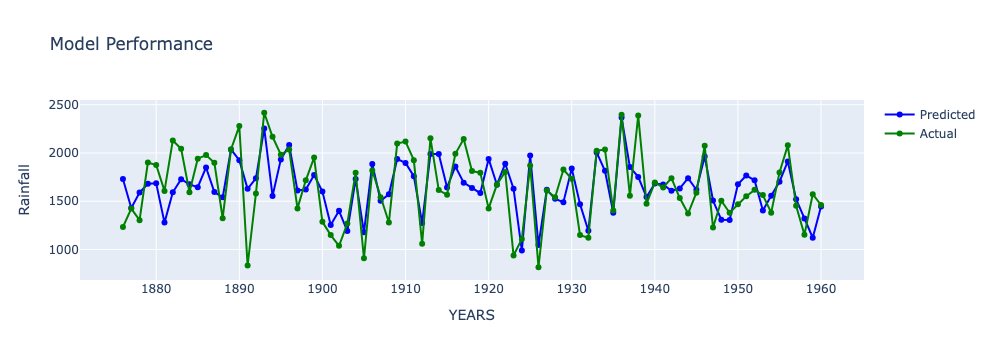

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


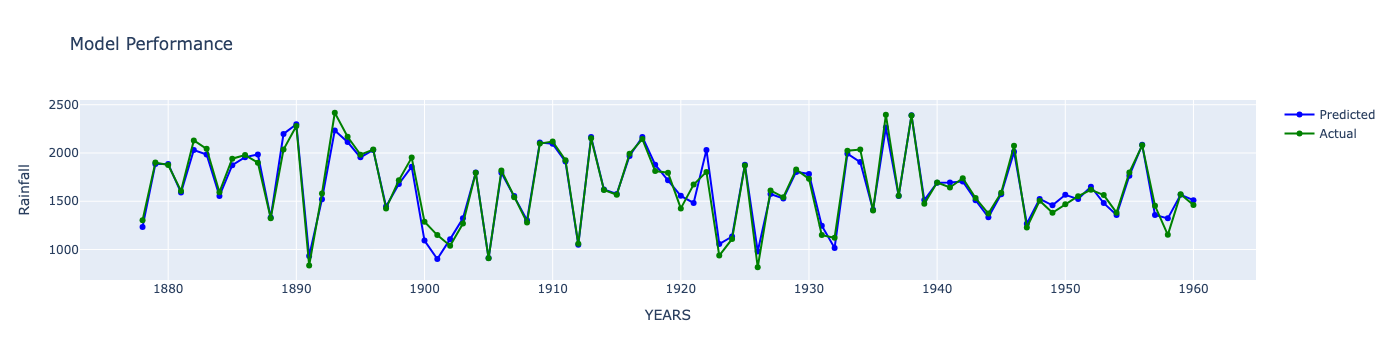

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


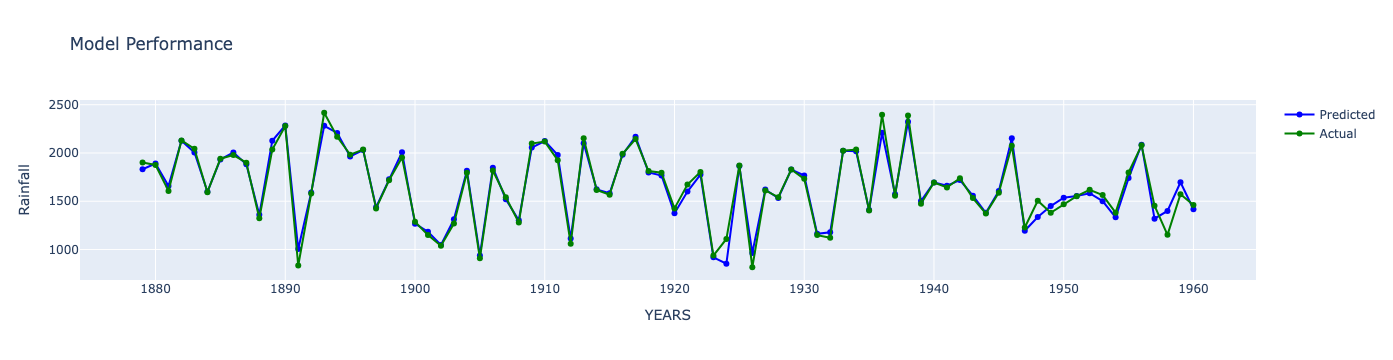

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


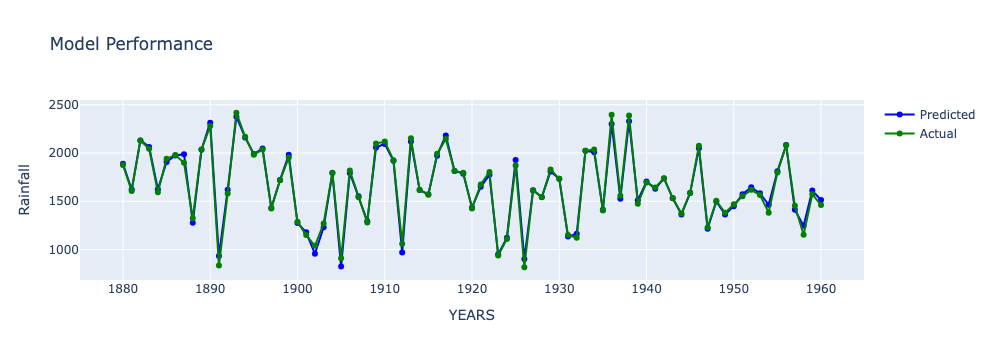

    Year  Actual          bp1          bp2          bp3          bp4  \
0   1876  1233.0  1729.566895     0.000000     0.000000     0.000000   
1   1877  1424.0  1430.074341  1533.869629     0.000000     0.000000   
2   1878  1304.0  1590.620972  1345.394287  1234.295044     0.000000   
3   1879  1901.0  1681.015625  1921.619019  1885.326294  1831.849854   
4   1880  1876.0  1685.717407  1908.480347  1887.071289  1889.908813   
..   ...     ...          ...          ...          ...          ...   
80  1956  2079.0  1912.568726  2148.806641  2084.464111  2086.368652   
81  1957  1453.0  1520.603760  1249.645264  1357.060547  1319.284668   
82  1958  1152.0  1321.888184  1470.681152  1322.538086  1399.117676   
83  1959  1573.0  1121.648315  1473.187988  1567.446289  1697.067383   
84  1960  1461.0  1446.508057  1569.094238  1510.755127  1417.145752   

            bp5     ensemble  
0      0.000000  1729.566895  
1      0.000000  1481.971985  
2      0.000000  1390.103434  
3      0.00

In [48]:
np.random.seed(8)
tf.random.set_seed(8)
random.seed(8)

for i in range(5):
    layers = 5+i 
    data = June_Data_all[i]
    year_start = 1876 + i
    min_val = data.min()
    max_val = data.max()
    y, y_pred = train_bp_model(layers, data, min_val, max_val)
    year_start = 1876 + i
    column = 'bp' + str(i+1)

    y_true, y_pred_denorm = denorm_values(y, y_pred, max_val, min_val)
    df_results = insert_pred_data(df_results, y_pred_denorm, year_start, column)
    mapping_graph(y_true, y_pred_denorm, year_start)


print(df_results)

In [54]:
# Function to calculate the average, ignoring zeros
def calculate_ensemble(row):
    non_zero_values = [val for val in row if val != 0]  # Get only non-zero values
    if len(non_zero_values) > 0:
        return sum(non_zero_values) / len(non_zero_values)  # Average of non-zero values
    else:
        return 0  # If all values are zero, return 0

# Apply the ensemble calculation across each row for 'bp1', 'bp2', 'bp3', 'bp4', and 'bp5'
df_results['ensemble'] = df_results[['bp1', 'bp2', 'bp3', 'bp4', 'bp5']].apply(calculate_ensemble, axis=1)

# Display the updated DataFrame
print(df_results.head())

   Year  Actual          bp1          bp2          bp3          bp4  \
0  1876  1233.0  1729.566895     0.000000     0.000000     0.000000   
1  1877  1424.0  1430.074341  1533.869629     0.000000     0.000000   
2  1878  1304.0  1590.620972  1345.394287  1234.295044     0.000000   
3  1879  1901.0  1681.015625  1921.619019  1885.326294  1831.849854   
4  1880  1876.0  1685.717407  1908.480347  1887.071289  1889.908813   

           bp5     ensemble  
0     0.000000  1729.566895  
1     0.000000  1481.971985  
2     0.000000  1390.103434  
3     0.000000  1829.952698  
4  1888.678833  1851.971338  


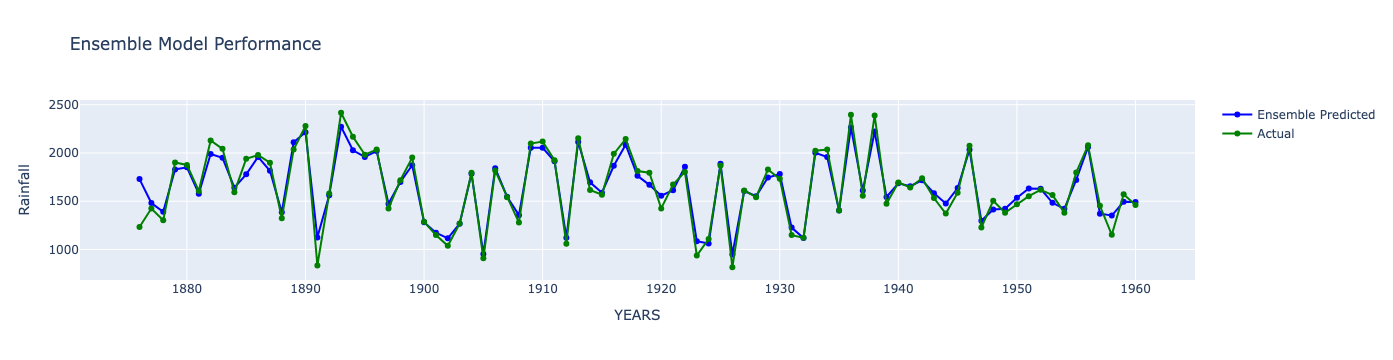

RMSE: 97.00158829119967
R^2: 0.9319590713451966
Mean Predicted: 1648.749517654718
Standard Deviation Predicted: 316.20087795645827
Percentage of Prediction (PP): 0.34348624570724295


In [56]:
def mapping_ensemble_graph(y_actual, y_ensemble, year_start):
    years = np.arange(year_start, year_start + len(y_ensemble))
    
    trace_ensemble = go.Scatter(x=years, y=y_ensemble, mode='lines+markers', name='Ensemble Predicted', line=dict(color='blue'))
    trace_actual = go.Scatter(x=years, y=y_actual, mode='lines+markers', name='Actual', line=dict(color='green'))
    
    layout = go.Layout(title='Ensemble Model Performance', xaxis=dict(title='YEARS'), yaxis=dict(title='Rainfall'))
    fig = go.Figure(data=[trace_ensemble, trace_actual], layout=layout)

    pio.show(fig)


# Assuming 'y' contains actual values and 'ensemble' contains the ensemble predictions:
mapping_ensemble_graph(df_results['Actual'], df_results['ensemble'], 1876)

metrics = calculate_metrics(df_results['Actual'], df_results['ensemble'])
for key, value in metrics.items():
    print(f'{key}: {value}')

In [ ]:
# from sklearn.model_selection import ParameterGrid

# batch_sizes = [8, 16, 32, 64, 128]

# def grid_search_batch_size(layers, data):
#     best_rmse = float('inf')
#     best_batch_size = None

#     for batch_size in batch_sizes:
#         print(f"Training with batch size: {batch_size}")
#         y, y_pred = train_bp_model(layers, data, batch_size=batch_size)
        
#         # RMSE Calculation
#         rmse = np.sqrt(mean_squared_error(y, y_pred))
#         print(f"Batch size: {batch_size}, RMSE: {rmse}")

#         # Keep track of the best batch size
#         if rmse < best_rmse:
#             best_rmse = rmse
#             best_batch_size = batch_size

#     print(f"Best batch size: {best_batch_size} with RMSE: {best_rmse}")
#     return best_batch_size

# layers = 9  # Example for BP1
# data = June_Data_all[4]  # Example for BP1 data
# best_batch_size = grid_search_batch_size(layers, data)

# # # Use the best batch size to train all models
# # for i in range(5):
# #     layers = 5 + i  # Increment layers
# #     data = June_Data_all[i]  # Select corresponding data
# #     y, y_pred = train_bp_model(layers, data, batch_size=best_batch_size)  # Use the best batch size


BP1 :-  8 <br>
BP2 :-  16 <br>
BP3 :-  16 <br>
BP4 :-  16  <br>
BP5 :-  16

In [ ]:
# del data, data2, data3, dataset, JUN_BP1, JUN_BP2, JUN_BP3, JUN_BP4, JUN_BP5, JUL_BP1, JUL_BP2, JUL_BP3, JUL_BP4, JUL_BP5, AUG_BP1, AUG_BP2, AUG_BP3, AUG_BP4, AUG_BP5, SEP_BP1, SEP_BP2, SEP_BP3, SEP_BP4, SEP_BP5, SEAS_BP1, SEAS_BP2, SEAS_BP3, SEAS_BP4, SEAS_BP5